In [10]:
import torch, os, copy, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

from src.mechanism_base import *
from src.model_base import EmbedMLP
from src.utils import cross_entropy_high_precision, acc_rate

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loading on device: {device}")

plt.rcParams['mathtext.fontset'] = 'cm'
colors = ['#0D2758', '#60656F', '#DEA54B', '#A32015', '#347186']


Loading on device: cpu


## Training Results using AdamW (standard)

In [11]:
# Define the base path where the model and data files are stored
base_path = '../src/saved_models/p_23_dmlp_512_ReLU_random_scale_0.1_decay_0_11122351' 

# Set model configuration parameters
d_vocab, d_model, d_mlp, act_type = 23, 23, 512, 'ReLU'  # Vocabulary size, model dimension, MLP size, and activation type
p = d_vocab  # Assign vocabulary size to variable `p`

# Define the file names for the model and data files
model_file = 'final.pth'        # File containing the trained model
train_data_file = 'train_data.pth'  # File containing the training data
test_data_file = 'test_data.pth'   # File containing the test data

# Load the training and testing data
train_data = torch.load(
    os.path.join(base_path, train_data_file),  # Path to the training data file
    weights_only=True,                         # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                        # Specify the device to load the data onto
)
test_data = torch.load(
    os.path.join(base_path, test_data_file),   # Path to the testing data file
    weights_only=True,                         # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                        # Specify the device to load the data onto
)
# Load the model and data on the specified device
model_data = torch.load(
    os.path.join(base_path, model_file),   # Path to the model file
    weights_only=True,                    # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                   # Specify the device to load the model onto
)
print(f"Trained Model Dict: {model_data.keys()}\n")  # Print the keys of the loaded model dictionary

# Extract the model parameters from the loaded model dictionary
model_load = model_data["model"]  # Access the model section of the dictionary
model_load['mlp.W_in'] = model_load['mlp.W_in'] @ model_load['embed.W_E']

for key in model_load.keys():
    # Print each model parameter's key and its shape in a formatted manner
    print(f"{key:<30} {str(model_load[key].shape):<25}")


Trained Model Dict: dict_keys(['model', 'train_loss', 'test_loss', 'train_losses', 'test_losses', 'grad_norms', 'param_norms', 'epoch', 'optimizer', 'scheduler'])

embed.W_E                      torch.Size([128, 23])    
mlp.W_in                       torch.Size([512, 23])    
mlp.W_out                      torch.Size([23, 512])    
mlp.basis                      torch.Size([23, 23])     


In [12]:
all_data = torch.tensor([(i, j) for i in range(p) for j in range(p)]).to(device)
all_labels = torch.tensor([(i + j) % p for i, j in all_data]).to(device)
train_labels = torch.tensor([(i + j) % p for i, j in train_data]).to(device)

fourier_basis, fourier_basis_names = get_fourier_basis(p, device)

In [13]:
all_files = [os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f))]

loaded_files = {} # Initialize the dictionary to store the loaded files
exclude_files = {'final.pth', 'test_data.pth', 'train_data.pth'} # Define the files to exclude

# Loop through all files in the directory
for file_name in os.listdir(base_path):
    file_path = os.path.join(base_path, file_name)
    # Check if it's a file, has the correct extension, and is not in the exclude list
    if os.path.isfile(file_path) and file_name.endswith('.pth') and file_name not in exclude_files:
        # Extract the final ID from the filename (remove extension and convert to int)
        final_id = int(os.path.splitext(file_name)[0])
        # Load the file (assuming it's a PyTorch model)
        loaded_files[final_id] = torch.load(file_path, weights_only=True, map_location=device)["model"]
loaded_files = {key: loaded_files[key] for key in sorted(loaded_files)}

In [21]:
def plot_model(key):
    # Retrieve the model state dict using the selected key
    model_load = loaded_files[key]
    model_load['mlp.W_in'] = model_load['mlp.W_in'] @ model_load['embed.W_E']
    # Create the figure with two subplots
    plt.figure(figsize=(15, 10))
    
    # First subplot: Decoded W_in
    plt.subplot(1, 2, 1)
    # Compute data (example: W_in multiplied by the transpose of the fourier_basis)
    data_in = (model_load['mlp.W_in'][:40]) @ fourier_basis.T
    abs_max_in = np.abs(data_in).max()
    plt.imshow(data_in, cmap='RdBu', vmin=-abs_max_in, vmax=abs_max_in)
    plt.title('Decoded W_in')
    plt.colorbar(shrink=0.5)
    
    # Second subplot: Decoded W_out
    plt.subplot(1, 2, 2)
    # Compute data (example: transpose of W_out multiplied by the transpose of the fourier_basis)
    data_out = model_load['mlp.W_out'][:,:40].T @ fourier_basis.T
    abs_max_out = np.abs(data_out).max()
    plt.imshow(data_out, cmap='RdBu', vmin=-abs_max_out, vmax=abs_max_out)
    plt.title('Decoded W_out')
    plt.colorbar(shrink=0.5)

    plt.suptitle(f'Model Key: {key}')
    plt.show()

# Create a selection slider with the sorted keys from your loaded_files dictionary
key_options = sorted(loaded_files.keys())
interact(plot_model, key=widgets.SelectionSlider(options=key_options, description='Model Key'))


interactive(children=(SelectionSlider(description='Model Key', options=(0, 200, 400, 600, 800, 1000, 1200, 140…

<function __main__.plot_model(key)>

In [24]:
def interactive_model(key):
    # Clear previous outputs so the new model's output is shown clearly
    clear_output(wait=True)
    
    # Retrieve the model using the selected key
    model_load = loaded_files[key]
    #model_load['mlp.W_in'] = model_load['mlp.W_in'] @ model_load['embed.W_E']
    
    # Decode the weights from the selected model
    W_in_decode, W_out_decode, max_freq_ls = decode_weights(model_load, fourier_basis)
    
    # Determine the number of neurons (assuming the first dimension of W_in_decode equals d_mlp)
    d_mlp = W_in_decode.shape[0]
    print(f"Loaded Model Key: {key} with {d_mlp} neurons.\n")
    
    # Loop through each neuron and print the computed details
    for neuron in range(40):
        coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
        coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
        print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]}, "
              f"Scale {coeff_in_scale:.4f},{coeff_out_scale:.4f}, "
              f"2*Phi(in) {normalize_to_pi(2*coeff_in_phi):.2f}, "
              f"Phi(out) {coeff_out_phi:.2f}")

# Create an interactive widget for model selection using the keys in loaded_files.
model_keys = sorted(loaded_files.keys())
interact(interactive_model, key=widgets.SelectionSlider(options=model_keys, description='Model Key'));



interactive(children=(SelectionSlider(description='Model Key', options=(0, 200, 400, 600, 800, 1000, 1200, 140…

In [ ]:
W_in_decode, W_out_decode, max_freq_ls = decode_weights(model_load, fourier_basis)
coeff_in_scale_ls_all = []
coeff_out_scale_ls_all = []
coeff_phi_ls_all = []
coeff_psi_ls_all = []

for neuron in range(d_mlp):
    coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
    coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
    coeff_in_scale_ls_all.append(coeff_in_scale)
    coeff_phi_ls_all.append(coeff_in_phi)
    coeff_psi_ls_all.append(coeff_out_phi)
    if neuron < 20:
        print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]} , Scale {coeff_in_scale:.2f},{coeff_out_scale:.2f}, 2*Phi(in) {normalize_to_pi(2*coeff_in_phi):.2f}, Phi(out) {coeff_out_phi:.2f}")

Neuron 0: Freq 9 , Scale 1.01,0.25, 2*Phi(in) -2.55, Phi(out) -2.61
Neuron 1: Freq 1 , Scale 1.20,0.23, 2*Phi(in) 1.87, Phi(out) 1.96
Neuron 2: Freq 4 , Scale 1.14,0.23, 2*Phi(in) -1.06, Phi(out) -0.93
Neuron 3: Freq 3 , Scale 1.13,0.22, 2*Phi(in) 0.10, Phi(out) 0.08
Neuron 4: Freq 10 , Scale 1.15,0.23, 2*Phi(in) 0.29, Phi(out) 0.53
Neuron 5: Freq 1 , Scale 1.33,0.23, 2*Phi(in) 0.37, Phi(out) 0.37
Neuron 6: Freq 5 , Scale 1.19,0.24, 2*Phi(in) 1.44, Phi(out) 1.44
Neuron 7: Freq 4 , Scale 1.03,0.23, 2*Phi(in) 2.38, Phi(out) 2.30
Neuron 8: Freq 4 , Scale 1.05,0.23, 2*Phi(in) -0.38, Phi(out) -0.21
Neuron 9: Freq 4 , Scale 1.02,0.22, 2*Phi(in) -1.89, Phi(out) -2.04
Neuron 10: Freq 1 , Scale 1.20,0.23, 2*Phi(in) -2.84, Phi(out) -2.77
Neuron 11: Freq 1 , Scale 1.28,0.23, 2*Phi(in) -1.74, Phi(out) -1.88
Neuron 12: Freq 1 , Scale 1.23,0.23, 2*Phi(in) 1.32, Phi(out) 1.43
Neuron 13: Freq 2 , Scale 1.27,0.21, 2*Phi(in) 0.86, Phi(out) 0.98
Neuron 14: Freq 10 , Scale 1.40,0.25, 2*Phi(in) -2.18, Phi(

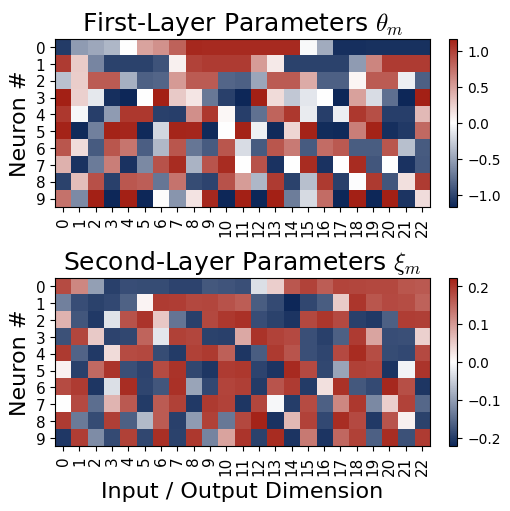

In [ ]:
# 1. Define the custom colormap
colors = ['#0D2758', '#60656F', '#DEA54B', '#A32015', '#347186']

cividis_with_white = LinearSegmentedColormap.from_list(
    'cividis_white_center',
    ['#0D2758', 'white', '#A32015'],
    N=256
)

# 2. Prepare data for plotting (as per your provided code)
freq_ls = np.array(max_freq_ls[30:40])
W_in_data_filtered = model_load['mlp.W_in'][30:40]
W_out_T_data_filtered = model_load['mlp.W_out'].T[30:40]

sorted_indices = np.argsort(freq_ls)
ranked_freq_ls = freq_ls[sorted_indices]
ranked_W_in_data = W_in_data_filtered[sorted_indices, :]
ranked_W_out_T_data = W_out_T_data_filtered[sorted_indices, :]

# 3. Create the figure and subplots
# Figure size adapted from the example's (12, 4*n) for (2,n) subplots.
# For this (2,1) layout (n=1 equivalent column), (7,9) provides a balanced look.
# gridspec_kw is also from the example to control spacing.
fig, axes = plt.subplots(2, 1, figsize=(5, 5), constrained_layout=True, gridspec_kw={"hspace": 0.05})

# --- Plot for W_in (Top Plot) ---
ax_in = axes[0]
abs_max_in = np.abs(ranked_W_in_data).max() * 1 # Your original scaling
im_in = ax_in.imshow(
    ranked_W_in_data,
    cmap=cividis_with_white,
    vmin=-abs_max_in,
    vmax=abs_max_in,
    aspect='auto'
)
ax_in.set_title(r'First-Layer Parameters $\theta_m$', fontsize=18) # Title fontsize from example
fig.colorbar(im_in, ax=ax_in)

# X/Y axis styling based on example
num_rows_in = ranked_W_in_data.shape[0]
num_cols_in = ranked_W_in_data.shape[1]
y_locs_in = np.arange(num_rows_in)
x_locs_in = np.arange(num_cols_in) # Assuming columns are simple indices

ax_in.set_yticks(y_locs_in)
ax_in.set_yticklabels(y_locs_in, fontsize=11) # Tick label fontsize from example
ax_in.set_ylabel('Neuron #', fontsize=16)     # Y-axis label and fontsize from example

ax_in.set_xticks(x_locs_in)
# Using column indices as x-tick labels, styled as per example
ax_in.set_xticklabels(x_locs_in, rotation=90, fontsize=11)
# Your original ax_in.set_xlabel is replaced by these more specific tick labels

# --- Plot for W_out.T (Bottom Plot) ---
ax_out = axes[1]
abs_max_out = np.abs(ranked_W_out_T_data).max() * 1 # Your original scaling
im_out = ax_out.imshow(
    ranked_W_out_T_data,
    cmap=cividis_with_white,
    vmin=-abs_max_out,
    vmax=abs_max_out,
    aspect='auto'
)
ax_out.set_title(r'Second-Layer Parameters $\xi_m$', fontsize=18) # Title fontsize from example
fig.colorbar(im_out, ax=ax_out)

# X/Y axis styling based on example
num_rows_out = ranked_W_out_T_data.shape[0]
num_cols_out = ranked_W_out_T_data.shape[1]
y_locs_out = np.arange(num_rows_out)
x_locs_out = np.arange(num_cols_out) # Assuming columns are simple indices

ax_out.set_yticks(y_locs_out)
ax_out.set_yticklabels(y_locs_out, fontsize=11) # Tick label fontsize from example
ax_out.set_ylabel('Neuron #', fontsize=16)     # Y-axis label and fontsize from example

ax_out.set_xticks(x_locs_out)
# Using column indices as x-tick labels, styled as per example
ax_out.set_xticklabels(x_locs_out, rotation=90, fontsize=11)
ax_out.set_xlabel('Input / Output Dimension', fontsize=16)
# Your original ax_out.set_xlabel is replaced
plt.savefig('../figures/full_training_para_origin.jpg', format='jpg', dpi=300, bbox_inches='tight')
# 4. Display the plot
plt.show()

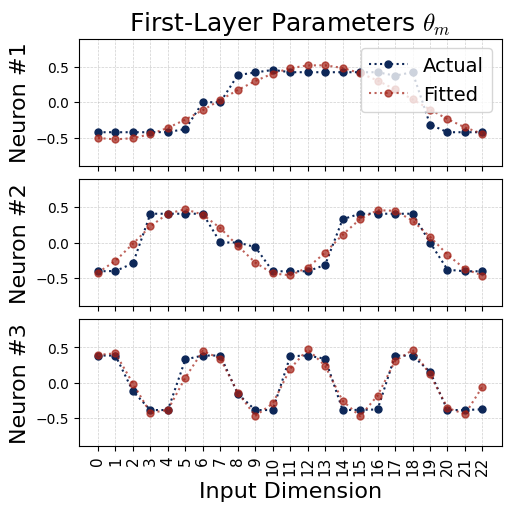

In [ ]:
# Specify which 3 neurons to plot (indices 2, 3, 4 by default)
neuron_indices = [0, 2, 4]  # Change these indices as needed

# Select the specified neurons from ranked_W_in_data
if hasattr(ranked_W_in_data, 'iloc'):
    top3 = ranked_W_in_data.iloc[neuron_indices]
else:
    top3 = ranked_W_in_data[neuron_indices]

fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(5, 5),
    constrained_layout=True,
    gridspec_kw={'hspace': 0.02}
)

# define tick positions first
positions = np.arange(len(x_locs_out))

for i, ax in enumerate(axes):
    data = top3.iloc[i].values if hasattr(top3, 'iloc') else top3[i]
    data_est = (p := data @ fourier_basis.T) * np.isin(np.arange(p.shape[0]), np.argpartition(-np.abs(p), 2)[:2]) @ fourier_basis
    ax.plot(data, marker='o', markersize=5, color=colors[0], linewidth=1.5, linestyle=':', label="Actual")
    ax.plot(data_est, marker='o', markersize=5, color=colors[3], linewidth=1.5, linestyle=':', alpha=0.7, label="Fitted")
    ax.set_ylim(-0.9, 0.9)
    ax.set_ylabel(f'Neuron #{i+1}', fontsize=16)
    # set common x-ticks for vertical grid lines
    ax.set_xticks(positions)
    # draw grid on both x and y axes
    ax.grid(True,
            which='major',
            axis='both',        # <--- grid on both axes
            linestyle='--',
            linewidth=0.5,
            alpha=0.6)

    # only bottom axis shows labels
    if i < len(axes) - 1:
        ax.set_xticklabels([])

# configure bottom subplot's ticks and labels properly
ax_bottom = axes[-1]
ax_bottom.set_xlabel('Input Dimension', fontsize=16)

# set tick positions and labels
ax_bottom.set_xticks(positions)
ax_bottom.set_xticklabels(x_locs_out, rotation=90, fontsize=11)
axes[0].set_title(r'First-Layer Parameters $\theta_m$', fontsize=18)
axes[0].legend(fontsize=14, loc="upper right")
plt.savefig('../figures/full_training_para_origin_lineplot_in.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

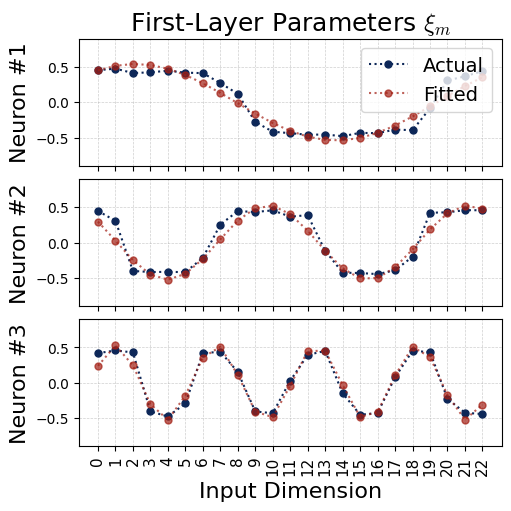

In [ ]:
# Specify which 3 neurons to plot (indices 2, 3, 4 by default)
neuron_indices = [0, 2, 4]  # Change these indices as needed

# Select the specified neurons from ranked_W_in_data
if hasattr(ranked_W_out_T_data, 'iloc'):
    top3 = ranked_W_out_T_data.iloc[neuron_indices]
else:
    top3 = ranked_W_out_T_data[neuron_indices]

fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(5, 5),
    constrained_layout=True,
    gridspec_kw={'hspace': 0.02}
)

# define tick positions first
positions = np.arange(len(x_locs_out))

for i, ax in enumerate(axes):
    data = top3.iloc[i].values if hasattr(top3, 'iloc') else top3[i]
    data_est = (p := data @ fourier_basis.T) * np.isin(np.arange(p.shape[0]), np.argpartition(-np.abs(p), 2)[:2]) @ fourier_basis
    ax.plot(data, marker='o', markersize=5, color=colors[0], linewidth=1.5, linestyle=':', label="Actual")
    ax.plot(data_est, marker='o', markersize=5, color=colors[3], linewidth=1.5, linestyle=':', alpha=0.7, label="Fitted")
    ax.set_ylim(-0.9, 0.9)
    ax.set_ylabel(f'Neuron #{i+1}', fontsize=16)
    # set common x-ticks for vertical grid lines
    ax.set_xticks(positions)
    # draw grid on both x and y axes
    ax.grid(True,
            which='major',
            axis='both',        # <--- grid on both axes
            linestyle='--',
            linewidth=0.5,
            alpha=0.6)

    # only bottom axis shows labels
    if i < len(axes) - 1:
        ax.set_xticklabels([])

# configure bottom subplot's ticks and labels properly
ax_bottom = axes[-1]
ax_bottom.set_xlabel('Input Dimension', fontsize=16)

# set tick positions and labels
ax_bottom.set_xticks(positions)
ax_bottom.set_xticklabels(x_locs_out, rotation=90, fontsize=11)
axes[0].set_title(r'First-Layer Parameters $\xi_m$', fontsize=18)
axes[0].legend(fontsize=14, loc="upper right")
plt.savefig('../figures/full_training_para_origin_lineplot_out.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
coeff_scale_ls = []
coeff_phi_ls = []
freq = 3

for neuron in [i for i, value in enumerate(max_freq_ls) if value == freq]:
    _, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
    _, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
    coeff_phi_ls.append(coeff_in_phi)
    #print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]}, Scale(in,out) {coeff_in_scale: .2f},{coeff_out_scale: .2f}, Phi(out) {normalize_to_pi(coeff_out_phi): .2f}, Phi(in)*2 {normalize_to_pi(2*coeff_in_phi): .2f}")

coeff_phi_ls = np.array(coeff_phi_ls)

# assume coeff_phi_ls is your 1D array of φₘ
multipliers = [1, 2, 3, 4,5,6,7,8]
results = {}

for m in multipliers:
    mean_cos = np.mean(np.cos(m * coeff_phi_ls))
    mean_sin = np.mean(np.sin(m * coeff_phi_ls))
    results[m] = (mean_cos, mean_sin)

# print them out
for m, (c, s) in results.items():
    print(f"m={m:>1} → ⟨cos({m}φₘ)⟩ = {c:.4f}, ⟨sin({m}φₘ)⟩ = {s:.4f}")


m=1 → ⟨cos(1φₘ)⟩ = -0.0123, ⟨sin(1φₘ)⟩ = -0.0500
m=2 → ⟨cos(2φₘ)⟩ = -0.0234, ⟨sin(2φₘ)⟩ = 0.0319
m=3 → ⟨cos(3φₘ)⟩ = 0.0531, ⟨sin(3φₘ)⟩ = 0.0032
m=4 → ⟨cos(4φₘ)⟩ = 0.0235, ⟨sin(4φₘ)⟩ = -0.0451
m=5 → ⟨cos(5φₘ)⟩ = -0.0505, ⟨sin(5φₘ)⟩ = 0.0372
m=6 → ⟨cos(6φₘ)⟩ = 0.0183, ⟨sin(6φₘ)⟩ = 0.0851
m=7 → ⟨cos(7φₘ)⟩ = 0.0936, ⟨sin(7φₘ)⟩ = -0.1616
m=8 → ⟨cos(8φₘ)⟩ = -0.1175, ⟨sin(8φₘ)⟩ = 0.0903


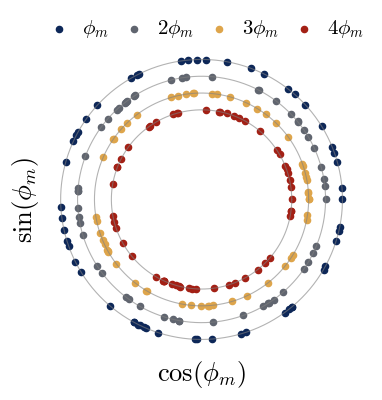

In [ ]:
theta = np.linspace(0, 2*np.pi, 300)

# define multipliers and a matching sequence of radii
multipliers = [1, 2, 3, 4]
radii       = [1.0, 0.88, 0.76, 0.64]

fig, ax = plt.subplots(figsize=(4,4))

for m, r in zip(multipliers, radii):
    # draw the circle of radius r
    x_c, y_c = r*np.cos(theta), r*np.sin(theta)
    ax.plot(x_c, y_c, linewidth=0.8, color='gray', alpha=0.6)
    
    # compute and plot points at angles m*φₘ, but on that circle of radius r
    x_pts = r * np.cos(m * coeff_phi_ls)
    y_pts = r * np.sin(m * coeff_phi_ls)
    if m > 1:
        ax.scatter(
            x_pts, y_pts,
            s=20,
            marker='o',
            color=colors[m-1],
            label=fr'${m}\phi_m$'
        )
    else:
        ax.scatter(
            x_pts, y_pts,
            s=20,
            marker='o',
            color=colors[m-1],
            label=fr'$\phi_m$'
        )


# floating legend
ax.legend(
    fontsize=15,
    loc='upper center',
    columnspacing=0.2,
    handletextpad=0.1,
    bbox_to_anchor=(0.5, 1.15),
    ncol=4,
    frameon=False
)

ax.set_xlabel(r'$\cos(\phi_m)$', fontsize=19)
ax.set_ylabel(r'$\sin(\phi_m)$', fontsize=19)

ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
# strip away all axes and spines
#ax.set_axis_off()
plt.savefig('../figures/full_training_phase_distribution.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

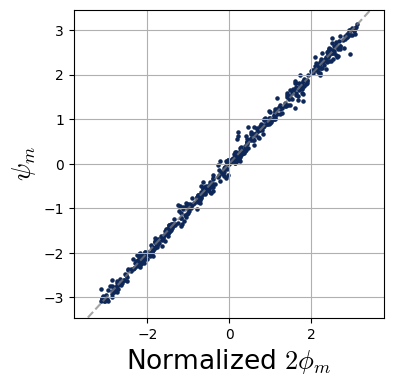

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

coeff_2phi_ls_all = np.array([normalize_to_pi(2*φ) for φ in coeff_phi_ls_all])
coeff_psi_ls_all  = np.array(coeff_psi_ls_all)
coeff_phi_ls_all  = np.array(coeff_phi_ls_all)

cond = ((coeff_2phi_ls_all / coeff_psi_ls_all < 0) & (coeff_2phi_ls_all < -2.8)) | ((coeff_2phi_ls_all / coeff_psi_ls_all < 0) & (coeff_2phi_ls_all > 2.8))

fig, ax = plt.subplots(figsize=(4,4))

# scatter points
ax.scatter(
    coeff_2phi_ls_all[~cond],
    coeff_psi_ls_all[~cond],
    marker='.',
    color=colors[0],
    s=20
)
# ax.scatter(
#     coeff_phi_ls_all[~cond],
#     coeff_psi_ls_all[~cond],
#     marker='.',
#     color=colors[0],
#     s=20,
#     label=r'$(\phi_m,\psi_m)$'
# )

# add reference lines
x_min, x_max = ax.get_xlim()
x_line = np.linspace(x_min, x_max, 200)
ax.plot(x_line,   x_line,       linestyle='--', color='gray', alpha=0.7)
# ax.plot(x_line,   2*x_line,     linestyle='--', color='gray', alpha=0.7)
# ax.plot(x_line,   2*x_line+2*np.pi, linestyle='--', color='gray', alpha=0.7)
# ax.plot(x_line,   2*x_line-2*np.pi, linestyle='--', color='gray', alpha=0.7)

# labels & grid
ax.set_xlabel(r'Normalized $2\phi_m$', fontsize=19)
ax.set_ylabel(r'$\psi_m$', fontsize=19)
ax.set_ylim(-np.pi*1.1, np.pi*1.1)
ax.grid(True)

# legend above plot
# ax.legend(
#     fontsize=16,
#     ncol=2,
#     loc='upper center',
#     frameon=False,
#     bbox_to_anchor=(0.5, 1.25),
#     columnspacing=0.4,   # horizontal space between columns
#     handletextpad=0.1,   # space between marker and text
#     labelspacing=0.2,    # vertical space between rows (not used for single row)
#     borderaxespad=0.9   # padding between axes and legend box
# )

plt.savefig('../figures/full_training_phase_relationship.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()


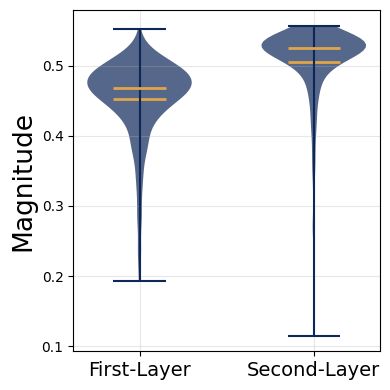

In [ ]:
coeff_scale_in_ls = []
coeff_scale_out_ls = []

for neuron in range(d_mlp):
    coeff_in_scale, _ = compute_neuron(neuron, max_freq_ls, W_in_decode)
    coeff_out_scale, _ = compute_neuron(neuron, max_freq_ls, W_out_decode)
    coeff_scale_in_ls.append(coeff_in_scale)
    coeff_scale_out_ls.append(coeff_out_scale)

# Create violin plot to show distribution of the two magnitudes
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(4, 4))

# Prepare data for violin plot
data_for_plot = [coeff_scale_in_ls, coeff_scale_out_ls]
positions = [1, 2]

# Create violin plot
parts = ax.violinplot(data_for_plot, positions=positions, widths=0.6, 
                       showmeans=True, showmedians=True, showextrema=True)

# Customize colors
for pc in parts['bodies']:
    pc.set_facecolor(colors[0])
    pc.set_alpha(0.7)

# Customize median lines (bars)
parts['cmedians'].set_color(colors[2])  # Red color for median
parts['cmedians'].set_linewidth(2)

# Customize mean lines
parts['cmeans'].set_color(colors[2])  # Orange/yellow color for mean
parts['cmeans'].set_linewidth(2)

# Customize bars (min/max lines)
parts['cbars'].set_color(colors[0])
parts['cbars'].set_linewidth(1.5)

# Customize caps (extrema)
parts['cmaxes'].set_color(colors[0])
parts['cmins'].set_color(colors[0])

# Set labels
ax.set_xticks(positions)
ax.set_xticklabels(['First-Layer', 'Second-Layer'], fontsize=14)
ax.set_ylabel('Magnitude', fontsize=19)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/full_training_magnitude_distribution.jpg', format='jpg', dpi=300, bbox_inches='tight')

In [ ]:
# Dictionary of different activation functions to test
activation_functions = {
      '|x|': lambda x: torch.abs(x),
      'x^2': lambda x: x**2,
      'x^4': lambda x: x**4,
      'x^8': lambda x: x**8,
      'log(1+e^2x)': lambda x: torch.log(1+torch.exp(2*x)),
      'e^x': lambda x: torch.exp(x),
      'x': lambda x: x,
      'x^3': lambda x: x**3,
  }

# Store results
results = {}

# Test each activation function
for name, activation_fn in activation_functions.items():
    # Create model with new activation
    modified_model = EmbedMLP(
        d_vocab=d_vocab,
        d_model=d_model,
        d_mlp=d_mlp,
        act_type=activation_fn,
        use_cache=False
    )
    modified_model.to(device)

    # Load the pre-trained weights
    modified_model.load_state_dict(model_load)

    # Set up caching if needed
    all_cache = {}
    modified_model.remove_all_hooks()
    modified_model.cache_all(all_cache)

    # Forward pass
    logits = modified_model(all_data).squeeze(1)
    loss = cross_entropy_high_precision(logits, all_labels)
    acc = acc_rate(logits, all_labels)

    # Store results
    results[name] = {
        'loss': loss.item(),
        'accuracy': acc,
      }

    print(f"{name:20s} | Loss: {loss.item():.6f} | Accuracy: {acc:.4f}")


|x|                  | Loss: -0.000000 | Accuracy: 1.0000
x^2                  | Loss: -0.000000 | Accuracy: 1.0000
x^4                  | Loss: 0.000031 | Accuracy: 1.0000
x^8                  | Loss: 0.051239 | Accuracy: 1.0000
log(1+e^2x)          | Loss: 0.001288 | Accuracy: 1.0000
e^x                  | Loss: 0.000654 | Accuracy: 1.0000
x                    | Loss: 4.246749 | Accuracy: 0.0416
x^3                  | Loss: 3.891341 | Accuracy: 0.0359


## Training Results using GD

In [ ]:
# Define the base path where the model and data files are stored
base_path = '/gpfs/radev/home/jh3439/module-addition-feature/src/saved_models/p_23_dmlp_512_ReLU_random_scale_0.01_decay_0_08151859' # Full random, ReLU, Small Init, AdamW

all_files = [os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f))]

loaded_files = {} # Initialize the dictionary to store the loaded files
exclude_files = {'final.pth', 'test_data.pth', 'train_data.pth'} # Define the files to exclude

# Loop through all files in the directory
for file_name in os.listdir(base_path):
    file_path = os.path.join(base_path, file_name)
    # Check if it's a file, has the correct extension, and is not in the exclude list
    if os.path.isfile(file_path) and file_name.endswith('.pth') and file_name not in exclude_files:
        # Extract the final ID from the filename (remove extension and convert to int)
        final_id = int(os.path.splitext(file_name)[0])
        # Load the file (assuming it's a PyTorch model)
        loaded_files[final_id] = torch.load(file_path, weights_only=True, map_location=device)["model"]
loaded_files = {key: loaded_files[key] for key in sorted(loaded_files)}

model_data = torch.load(
    os.path.join(base_path, 'final.pth'),   # Path to the model file
    weights_only=True,                    # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                   # Specify the device to load the model onto
)

In [ ]:
# Create a single list of all neuron‐records (dropping the model key)
sparse_level_ls =[]

for model in loaded_files.values():
    # Decode this model’s weights
    W_in_decode, W_out_decode, max_freq_ls = decode_weights(model, fourier_basis)
    d_mlp = W_in_decode.shape[0]
    sparse_level_ls.append((W_in_decode.norm(p=4, dim=1)**4/W_in_decode.norm(p=2, dim=1)**4).mean()/2 + (W_out_decode.norm(p=4, dim=1)**4/W_out_decode.norm(p=2, dim=1)**4).mean()/2)

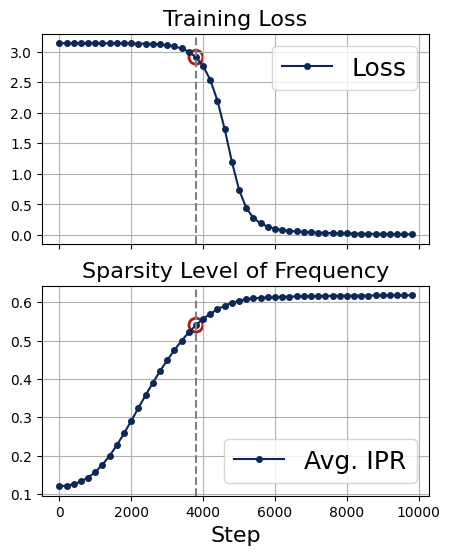

In [ ]:
vline_x = 3800
vline_kwargs = dict(color='gray', linestyle='--', linewidth=1.5)

# X-axis scaled by 1000
x = np.arange(len(sparse_level_ls)) * 200

# precompute your y-data slices
y_loss       = model_data["train_losses"][::200]
y_sparsity   = sparse_level_ls

# find the index of the point closest to x=20000
idx = np.argmin(np.abs(x - vline_x))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

# --- Loss plot
ax1.plot(x, y_loss,  marker='o', markersize=4, color=colors[0], label="Loss")
ax1.axvline(x=vline_x, **vline_kwargs)

# highlight the point
ax1.scatter( vline_x,
             y_loss[idx],
             s=100,                   # size of the highlight
             facecolors='none',       # hollow
             edgecolors=colors[3],        # red outline
             linewidths=2,
           )
ax1.set_title('Training Loss', fontsize=16)
ax1.legend(fontsize=18, loc="upper right")
ax1.grid(True)


# --- Sparsity plot
ax2.plot(x, y_sparsity,  marker='o', markersize=4, color=colors[0], label="Avg. IPR")
ax2.axvline(x=vline_x, **vline_kwargs)
ax2.scatter( vline_x,
             y_sparsity[idx],
             s=100,
             facecolors='none',
             edgecolors=colors[3],
             linewidths=2,
           )
ax2.set_title('Sparsity Level of Frequency', fontsize=16)
ax2.set_xlabel('Step', fontsize=16)
ax2.legend(fontsize=18, loc="lower right")
ax2.grid(True)

plt.savefig('../figures/loss_sparsity_relu.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

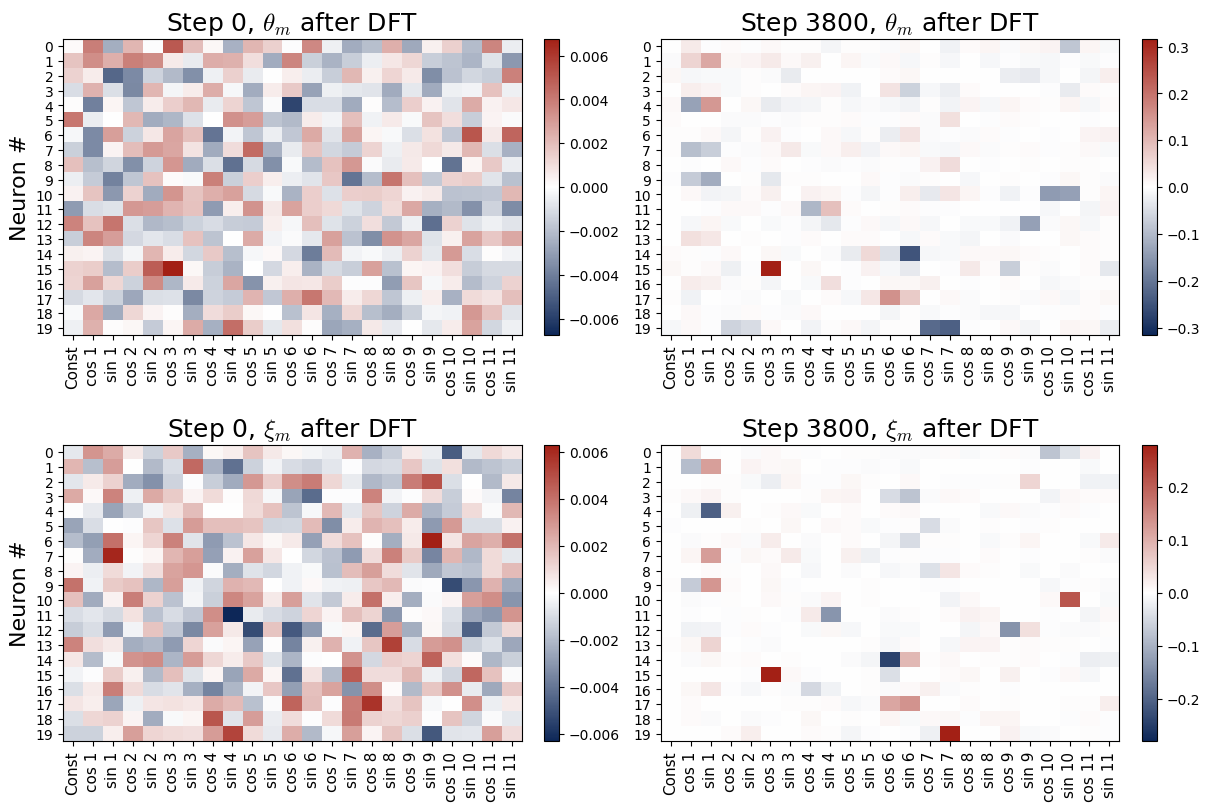

In [ ]:
# Create a custom colormap that centers 'cividis' with white at zero
cividis_with_white = LinearSegmentedColormap.from_list(
    'cividis_white_center', 
    ['#0D2758', 'white', '#A32015'],  # Colors at low, middle, and high points in 'cividis'
    N=256
)

def plot_decoded_weights(
    loaded_files,
    fourier_basis,
    fourier_basis_names,
    keys,
    num_components=20
):
    """
    Plots decoded W_in and W_out for each key in `keys`.

    Parameters
    ----------
    loaded_files : list of dict
        Each element is a dict containing 'mlp.W_in' and 'mlp.W_out'.
    fourier_basis : np.ndarray
        Your Fourier basis matrix of shape (p, p).
    fourier_basis_names : list of str
        Names/labels for each Fourier mode (length p).
    keys : list of int
        Indices into loaded_files to plot.
    num_components : int, optional
        How many top components (rows) to show, by default 20.
    """
    n = len(keys)
    #fig, axes = plt.subplots(2, n, figsize=(18, 3.3 * n), gridspec_kw={"hspace": 0.05}, constrained_layout=True)
    fig, axes = plt.subplots(2, n, figsize=(12, 4 * n), gridspec_kw={"hspace": 0.05}, constrained_layout=True)

    # Ensure axes is always 2×n
    if n == 1:
        axes = axes.reshape(2, 1)

    x_locs = np.arange(len(fourier_basis_names))
    y_locs = np.arange(num_components)

    for col, key in enumerate(keys):
        W_in = loaded_files[key]['mlp.W_in']
        W_out = loaded_files[key]['mlp.W_out']

        # --- Decoded W_in on row 0, col `col`
        data_in = (W_in @ fourier_basis.T)[:num_components]
        abs_max_in = np.abs(data_in).max()
        ax_in = axes[0, col]
        im_in = ax_in.imshow(
            data_in,
            cmap=cividis_with_white,
            vmin=-abs_max_in,
            vmax= abs_max_in,
            aspect='auto'
        )
        ax_in.set_title(rf'Step {key}, $\theta_m$ after DFT', fontsize=18)
        ax_in.set_xticks(x_locs)
        ax_in.set_xticklabels(fourier_basis_names, rotation=90, fontsize=11)
        ax_in.set_yticks(y_locs)
        ax_in.set_yticklabels(y_locs)
        if key == 0: ax_in.set_ylabel('Neuron #', fontsize=16)
        fig.colorbar(im_in, ax=ax_in)

        # --- Decoded W_out on row 1, col `col`
        data_out = (W_out.T @ fourier_basis.T)[:num_components]
        abs_max_out = np.abs(data_out).max() * 0.85
        ax_out = axes[1, col]
        im_out = ax_out.imshow(
            data_out,
            cmap=cividis_with_white,
            vmin=-abs_max_out,
            vmax= abs_max_out,
            aspect='auto'
        )
        ax_out.set_title(rf'Step {key}, $\xi_m$ after DFT', fontsize=18)
        ax_out.set_xticks(x_locs)
        ax_out.set_xticklabels(fourier_basis_names, rotation=90, fontsize=11)
        ax_out.set_yticks(y_locs)
        ax_out.set_yticklabels(y_locs)
        if key == 0: ax_out.set_ylabel('Neuron #', fontsize=16)
        fig.colorbar(im_out, ax=ax_out)

    plt.savefig('../figures/single_freq_relu_full_random_init.jpg', format='jpg', dpi=300, bbox_inches='tight')
    plt.show()


# Example usage:
keys = [0, 3800]  # whatever subset of loaded_files you want
plot_decoded_weights(loaded_files, fourier_basis, fourier_basis_names, keys, num_components=20)


In [ ]:
N = 8
phases = np.linspace(0, 2*np.pi, N, endpoint=False)
scale_in, scale_out = 1, 1
x, y = 4,6
p = 7

output = np.zeros(p)

for k in range(1, p//2+1):
    w_k = 2 * np.pi * k / p
    for phase in phases:
        output += scale_in * np.cos(w_k * np.arange(p) + phase*2) * (scale_out * np.cos(w_k * x + phase) + scale_out * np.cos(w_k * y + phase))**2
print (output)
print([-scale_in * scale_out**2 * N/2 + scale_in * scale_out**2 * N * p/4 * (i==(x+y)%p) + scale_in * scale_out**2 * N * p/8 * ((i==(2*x) %p) + (i==(2*y)%p)) for i in range(p)])

[-4.  3. -4. 10. -4.  3. -4.]
[-4.0, 3.0, -4.0, 10.0, -4.0, 3.0, -4.0]


In [ ]:
# Reset to default float32 for model compatibility
torch.set_default_dtype(torch.float32)

# Define the base path where the model and data files are stored
base_path = '../src/saved_models/p_23_dmlp_512_ReLU_random_scale_0.1_decay_0_08142058'

# Set model configuration parameters
d_vocab, d_model, d_mlp, act_type = 23, 23, 512, 'ReLU'  # Vocabulary size, model dimension, MLP size, and activation type
p = d_vocab  # Assign vocabulary size to variable `p`
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_data = torch.load(
    os.path.join(base_path, "final.pth"),   # Path to the model file
    weights_only=True,                    # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                   # Specify the device to load the model onto
)
model_load = model_data["model"]

model = EmbedMLP(
    d_vocab=d_vocab,
    d_model=d_model,
    d_mlp=d_mlp,
    act_type="Quad",
    use_cache=False
    )
model.to(device)

# Load the pre-trained weights
model.load_state_dict(model_load)

# Set up caching if needed
all_cache = {}
model.remove_all_hooks()
model.cache_all(all_cache)
all_data = torch.tensor([(i, j) for i in range(p) for j in range(p)], dtype=torch.long).to(device)

logits = model(all_data).squeeze(1)
logits.size()

torch.Size([529, 23])

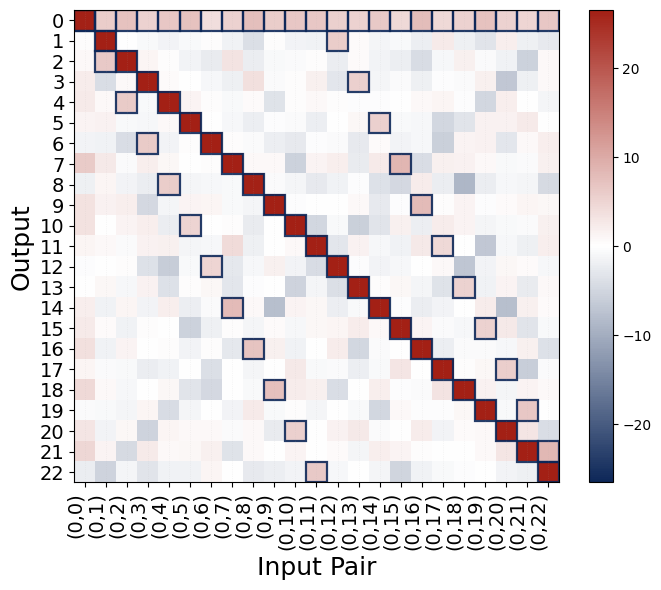

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import numpy as np

# Create a custom colormap that centers with white at zero
cividis_with_white = LinearSegmentedColormap.from_list(
    'cividis_white_center', 
    ['#0D2758', 'white', '#A32015'],  # Colors at low, middle, and high points
    N=256
)

# ========== FLEXIBLE INTERVAL PARAMETERS ==========
# Specify the interval of pairs to visualize
interval_start = p*0    # Starting index (0 to p^2-1)
interval_end = p*1     # Ending index (exclusive, max p^2 = 529)

# Alternative: specify by (i,j) coordinates
# i_start, j_start = 0, 0  
# i_end, j_end = 2, 5      
# interval_start = i_start * p + j_start
# interval_end = i_end * p + j_end
# ================================================

# Validate interval
interval_start = max(0, interval_start)
interval_end = min(len(all_data), interval_end)

# Convert logits to numpy
logits_np = logits.cpu().detach().numpy()

# Select the interval
logits_interval = logits_np[interval_start:interval_end]
selected_pairs = all_data[interval_start:interval_end]

# Create the heatmap
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(
    logits_interval.T,  # Transpose to have output classes on y-axis
    cmap=cividis_with_white,
    aspect='auto',
    vmin=-np.abs(logits_np).max()*0.8,
    vmax=np.abs(logits_np).max()*0.8
)

# Add highlighting rectangles
for i, (x, y) in enumerate(selected_pairs):
    x_val = x.item()
    y_val = y.item()
    
    # Calculate targets
    target_2x = (2 * x_val) % p
    target_2y = (2 * y_val) % p
    target_sum = (x_val + y_val) % p
    
    # Highlight j = 2x mod p or j = 2y mod p (purple)
    rect_2x = patches.Rectangle((i-0.5, target_2x-0.5), 1, 1, 
                                linewidth=1.6, edgecolor='#0D2758', 
                                facecolor='none', alpha=0.9)
    ax.add_patch(rect_2x)
    
    if target_2y != target_2x:
        rect_2y = patches.Rectangle((i-0.5, target_2y-0.5), 1, 1, 
                                    linewidth=1.6, edgecolor='#0D2758', 
                                    facecolor='none', alpha=0.9)
        ax.add_patch(rect_2y)
    
    # Highlight j = (x+y) mod p (green)
    rect_sum = patches.Rectangle((i-0.5, target_sum-0.5), 1, 1, 
                                 linewidth=1.6, edgecolor='#0D2758', 
                                 facecolor='none', alpha=0.9)
    ax.add_patch(rect_sum)

# Set labels for x-axis
n_pairs_shown = interval_end - interval_start
if n_pairs_shown <= 50:
    # Show all pairs
    x_positions = np.arange(n_pairs_shown)
    x_labels = [f"({selected_pairs[i][0]},{selected_pairs[i][1]})" for i in range(len(selected_pairs))]
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=14)
else:
    # Sample labels to avoid crowding
    n_labels = min(25, n_pairs_shown)
    step = n_pairs_shown // n_labels
    x_positions = np.arange(0, n_pairs_shown, step)
    x_labels = [f"({selected_pairs[i][0]},{selected_pairs[i][1]})" for i in x_positions]
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=14)

# Set labels for y-axis (output classes)
ax.set_yticks(np.arange(p))
ax.set_yticklabels(np.arange(p), fontsize=14)
ax.set_xlabel("Input Pair", fontsize=18)
ax.set_ylabel("Output", fontsize=18)

plt.colorbar(im, ax=ax)

# Add grid for better readability
ax.grid(True, alpha=0.2, linestyle=':', linewidth=0.5, axis='x')

plt.tight_layout()
plt.savefig('../figures/output_logits.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()